#  Modelado de Topics

**Topic Modelling** 

Conjunto de técnicas para descubrir estructuras latentes semánticas comunes (topics o temas) en un conjunto de documentos.

Consiste en identificar tópicos o temas en textos, detectando patrones en una colección de documentos "corpus" y agrupando las palabras que aparecen en los documentos.

*Topic Modelling generativo* es un modelo que permite la clasificación de documentos aún no procesados una vez que el modelo fue entrenado sin pasar por el corpus entero.

**LDA (Algoritmo Latent Dirichlet Allocation)** 

Es un modelo de topics probabilístico generativo, es decir asume que cada palabra en un documento es generada a partir de un topic que es tomado de una distribución de topics para cada documento. 

LDA permite que un documento sea parte de varios topics, cada uno con un peso diferente, es decir un documento es una distribución de topics y un topic es una distribución de palabras.

Este algoritmo asume:

- Documentos con topics similares usarán palabras similares
- Documentos compuestos por un conjunto de topics (con una determinada distribución)
- Topics compuestos por un conjunto de palabras (con una determinada distribución)

### Librerías y funciones necesarias

In [ ]:
# Librería gensim (complementaria a Spacy)
# Librería pyLDAvis 
!pip install gensim
!pip install pyLDAvis

In [ ]:
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary  # Diccionario clave:valor
from gensim.models import LdaModel, CoherenceModel  # Modelo LDA

import pyLDAvis  # Visualizar los clusters
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

### Lectura de datos

In [ ]:
# Lectura del dataset con los tweets del astrofísico Neil Degrasse Tyson
df = pd.read_csv('../datasets/NeildeGrasseTysonTweets.csv')
print(f'Dimensiones del dataset son: {df.shape}')

Dimensiones del dataset son: (2428, 7)


In [ ]:
df.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Aug 21,767371694834978816,/neiltyson/status/767371694834978817,False,"Moon’s shadow landfalls Oregon, crosses USA at...",deGrasseTyson
1,1,Oct 9,785186636946636800,/neiltyson/status/785186636946636800,False,"@huggy_panda Oink, oink. : - )",deGrasseTyson
2,2,Oct 9,785131023923314688,/neiltyson/status/785131023923314688,False,"Future headlines from the Multiverse: Nov 9, 2...",deGrasseTyson
3,3,Oct 7,784443331568930816,/neiltyson/status/784443331568930817,False,Awww. That’s the nicest thing anybody has said...,deGrasseTyson
4,4,Oct 6,784089429120020480,/neiltyson/status/784089429120020481,False,"If ComicCon people ruled the world, internatio...",deGrasseTyson


In [ ]:
# Análisis de la columna retweet
check_column(df, 'retweet')
df['retweet'].value_counts().head()

retweet consta de: 2 valores distintos de un total de 2428
retweet consta de: 0 valores ausentes, 0.0%


False    2424
True        4
Name: retweet, dtype: int64

In [ ]:
# Análisis de la columna text
check_column(df, 'text')
df['text'].value_counts().head()

text consta de: 2391 valores distintos de un total de 2428
text consta de: 0 valores ausentes, 0.0%


In 5-billion yrs the Sun will expand & engulf our orbit as the charred ember that was once Earth vaporizes. Have a nice day.     5
How to exaggerate: Prettiest in New York: Miss New York. Prettiest in USA: Miss America. Prettiest on Earth: Miss Universe       3
Why do aliens always disembark via ramp? Do they have problems with stairs? Or are flying saucers just handicap-accessible?      3
Just to settle it once and for all: Which came first the Chicken or the Egg? The Egg -- laid by a bird that was not a Chicken    3
I love the smell of the Universe in the morning.                                                                                 2
Name: text, dtype: int64

In [ ]:
# Nos quedamos únicamente con la columna text
df = df[['text']]
print(f'Dimensiones del dataset son: {df.shape}')
# No es necesario porque dicha columna no contiene valores ausentes pero lo contemplo 
# para futuros procesados de otros datasets que si contengan valores ausentes.
df.dropna(inplace=True)
print(f'Dimensiones del dataset son: {df.shape}')

Dimensiones del dataset son: (2428, 1)
Dimensiones del dataset son: (2428, 1)


### Preprocesado

In [ ]:
# gensim.utils.simple_preprocess: Convert a document into a list of lowercase tokens, 
# ignoring tokens that are too short or too long.
# doc : str.     Input document.
# deacc : bool, optional.     Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
# min_len : int, optional.    Minimum length of token (inclusive). Shorter tokens are discarded.
# max_len : int, optional.    Maximum length of token in result (inclusive). Longer tokens are discarded.
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [ ]:
print('Original text:\n{}\n\n'.format(df['text'][0]))
print('Processed text:\n{}'.format(text_preprocessing(df['text'][0])))

Original text:
Moon’s shadow landfalls Oregon, crosses USA at 1800mph, exits SCarolina. Behold ‘Muuurica’s Eclipse.pic.twitter.com/fIMCnEyyQy


Processed text:
['moon', 'shadow', 'landfalls', 'oregon', 'crosses', 'exits', 'scarolina', 'behold', 'muuurica', 'eclipse', 'twitter', 'fimcneyyqy']


In [ ]:
# lista de lista de documentos
processed_texts = []
for text in df['text']:
    processed_texts.append(text_preprocessing(text))

In [ ]:
processed_texts

[['moon',
  'shadow',
  'landfalls',
  'oregon',
  'crosses',
  'exits',
  'scarolina',
  'behold',
  'muuurica',
  'eclipse',
  'twitter',
  'fimcneyyqy'],
 ['huggy_panda', 'oink', 'oink'],
 ['future',
  'headlines',
  'multiverse',
  'trump',
  'hillary',
  'elected',
  'dismantling',
  'republican',
  'party'],
 ['awww',
  'nicest',
  'thing',
  'anybody',
  'said',
  'long',
  'https',
  'twitter',
  'ayeshatron',
  'status'],
 ['comiccon',
  'people',
  'ruled',
  'world',
  'international',
  'conflicts',
  'resolved',
  'entirely',
  'plastic',
  'light',
  'saber',
  'fights',
  'bars'],
 ['pluto',
  'year',
  'orbit',
  'birthdays',
  'incompatible',
  'human',
  'physiology'],
 ['ivychat',
  'maybe',
  'floating',
  'atmospheric',
  'balloon',
  'saturn',
  'atmosphere'],
 ['urge',
  'want',
  'information',
  'true',
  'clouds',
  'ability',
  'assess',
  'information',
  'false'],
 ['evidence',
  'internet',
  'cats',
  'rapidly',
  'achieving',
  'cosmic',
  'consciousness

In [ ]:
# processed_texts[25] = text_preprocessing(df['text'][25])
print(processed_texts[25])
print('Original text:\n{}\n\n'.format(df['text'][25]))
print('Processed text:\n{}'.format(text_preprocessing(df['text'][25])))

['enjoy', 'colorful', 'fireworks', 'tonight', 'thank', 'aluminum', 'barium', 'calcium', 'chlorine', 'copper', 'iron', 'nitrogen', 'oxygen', 'sodium', 'strontium']
Original text:
Will enjoy colorful fireworks tonight? Thank Aluminum Barium Calcium Chlorine Copper Iron Nitrogen Oxygen Sodium & Strontium.


Processed text:
['enjoy', 'colorful', 'fireworks', 'tonight', 'thank', 'aluminum', 'barium', 'calcium', 'chlorine', 'copper', 'iron', 'nitrogen', 'oxygen', 'sodium', 'strontium']


In [ ]:
processed_texts[25] == text_preprocessing(df['text'][25])

True

### Diccionario 

In [ ]:
# Función que genera un diccionario id-palabra a partir de unos textos
def get_dictionary (texts) :
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = Dictionary (texts)
    # dictionary . filter_extremes ( no_below =20 , no_above =0.5)
    # remove_n = 5 means number of the most frequent tokens that will be removed 
    dictionary.filter_n_most_frequent (5)
    return dictionary

In [ ]:
# Creación de un diccionario id-palabra
dictionary = get_dictionary(processed_texts)
print(f'Longitud del diccionario: ', {len(dictionary)})

print('Diccionario id,palabra: ')
list(dictionary.items())

Longitud del diccionario:  {6758}
Diccionario id,palabra: 


[(0, 'behold'),
 (1, 'crosses'),
 (2, 'eclipse'),
 (3, 'exits'),
 (4, 'fimcneyyqy'),
 (5, 'landfalls'),
 (6, 'muuurica'),
 (7, 'oregon'),
 (8, 'scarolina'),
 (9, 'shadow'),
 (10, 'twitter'),
 (11, 'huggy_panda'),
 (12, 'oink'),
 (13, 'dismantling'),
 (14, 'elected'),
 (15, 'future'),
 (16, 'headlines'),
 (17, 'hillary'),
 (18, 'multiverse'),
 (19, 'party'),
 (20, 'republican'),
 (21, 'trump'),
 (22, 'anybody'),
 (23, 'awww'),
 (24, 'ayeshatron'),
 (25, 'https'),
 (26, 'long'),
 (27, 'nicest'),
 (28, 'said'),
 (29, 'status'),
 (30, 'thing'),
 (31, 'bars'),
 (32, 'comiccon'),
 (33, 'conflicts'),
 (34, 'entirely'),
 (35, 'fights'),
 (36, 'international'),
 (37, 'light'),
 (38, 'plastic'),
 (39, 'resolved'),
 (40, 'ruled'),
 (41, 'saber'),
 (42, 'world'),
 (43, 'birthdays'),
 (44, 'human'),
 (45, 'incompatible'),
 (46, 'orbit'),
 (47, 'physiology'),
 (48, 'pluto'),
 (49, 'year'),
 (50, 'atmosphere'),
 (51, 'atmospheric'),
 (52, 'balloon'),
 (53, 'floating'),
 (54, 'ivychat'),
 (55, 'maybe'

### Matriz documento-palabra

In [ ]:
# Función que genera un corpus dado un diccionario y unos textos
def get_corpus (dictionary, texts) :
    # convert tokenized documents into a document - term matrix
    # doc2bow (document): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus


In [ ]:
# Creación de un corpus
corpus = get_corpus(dictionary, processed_texts)
print(f'Corpus: ')
corpus

Corpus: 


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1)],
 [(11, 1), (12, 2)],
 [(13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(10, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1)],
 [(31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1)],
 [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)],
 [(50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
 [(57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1)],
 [(25, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1)],
 [(62, 1), (69, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)],
 [(85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1)],
 [(46, 1), (91, 1)

In [ ]:
# Significa que las siguientes palabras o términos con id en el vocabulario se repiten el nº de veces indicado:
# huggy_panda con id 12 en el diccionario se repite 1 vez 
# oink con id 13 se repite 2 veces
print('Original  text:{}\n'.format(df['text'][1]))
print('Processed text:{}\n'.format(processed_texts[1]))
print('Corpus        :{}'.format(corpus[1]))


Original  text:@huggy_panda  Oink, oink.   : - )

Processed text:['huggy_panda', 'oink', 'oink']

Corpus        :[(11, 1), (12, 2)]


### Entrenamiento del modelo LDA

#### Número óptimo de tokens

Para obtener el nº óptimo de topics se construyen varios modelos  LDA con diferente nº de topics (num_topics) y se toma aquel que devuelva el mayor valor de coherencia (coherence score). Este valor de coherencia es una forma simple de ver cómo de bueno es el modelo.

Pero también es cierto que para la elección de num_topics, el valor del coherence score no tiene porque ser necesariamente el más grande porque si por ejemplo se detectan las mismas palabras repetidas en muchos de los topics, esto significa que el parámetro num_topics es muy grande.



In [ ]:
# Función que cálcula el valor de la coherencia entre varios modelos LDA y devuelve la lista de modelos junto con 
# la lista asociada del valor de la coherencia, de modo que podemos extraer el óptimo número de topics del modelo LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        # random_state: parameter is fundamental if you want to reproduce the training run, its like a random seed
        # passes: number of passes through the corpus during training.
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=15,
                                                alpha='auto',
                                                random_state = 1)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
start_ = 1  # Nº mínimo de topics
end_ = 20   # Nº máximo de topics
step_ = 1   # Salto de 1 en 1 

# LLamada a la función compute_coherence_values para el cálculo del nº óptimo de topics 
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

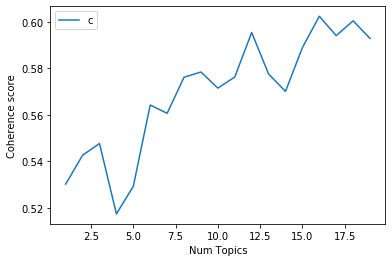

In [ ]:
# Visualizamos el resultado del valor de la coherencia por cada topic
# de manera que el topic con mayor coherencia es el valor óptimo para el modelo
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " con Coherence Score: ", round(cv, 4))

Num Topics = 1  con Coherence Score:  0.5302
Num Topics = 2  con Coherence Score:  0.5427
Num Topics = 3  con Coherence Score:  0.5477
Num Topics = 4  con Coherence Score:  0.5175
Num Topics = 5  con Coherence Score:  0.5293
Num Topics = 6  con Coherence Score:  0.5643
Num Topics = 7  con Coherence Score:  0.5607
Num Topics = 8  con Coherence Score:  0.5762
Num Topics = 9  con Coherence Score:  0.5785
Num Topics = 10  con Coherence Score:  0.5715
Num Topics = 11  con Coherence Score:  0.5763
Num Topics = 12  con Coherence Score:  0.5954
Num Topics = 13  con Coherence Score:  0.5776
Num Topics = 14  con Coherence Score:  0.5701
Num Topics = 15  con Coherence Score:  0.5889
Num Topics = 16  con Coherence Score:  0.6024
Num Topics = 17  con Coherence Score:  0.5941
Num Topics = 18  con Coherence Score:  0.6004
Num Topics = 19  con Coherence Score:  0.5929


    Según estos resultados, aunque el óptimo num_topics es 16, optamos por quedarnos con num_topics = 12 con posición a 11


In [ ]:
# Modelo LDA de gensim con el nº óptimo de topics seleccionados (num_topics a 12 con la posición 11)
num_topics = 12
optimal_model_id = 11

# Modelo con el óptimo nº de topics teniendo en cuenta la posición
optimal_model = model_list[optimal_model_id]

In [ ]:
# Get a representation for selected topics
optimal_model.show_topics(num_topics)

[(0,
  '0.012*"happy" + 0.010*"vegas" + 0.007*"equator" + 0.007*"north" + 0.007*"mathematics" + 0.007*"actually" + 0.006*"spring" + 0.006*"colbert" + 0.006*"atlantis" + 0.006*"know"'),
 (1,
  '0.015*"pluto" + 0.013*"scientists" + 0.011*"mars" + 0.011*"posted" + 0.009*"secret" + 0.009*"film" + 0.009*"america" + 0.008*"interested" + 0.008*"energy" + 0.008*"nova"'),
 (2,
  '0.014*"science" + 0.011*"good" + 0.008*"today" + 0.007*"space" + 0.007*"tweetphoto" + 0.006*"years" + 0.006*"water" + 0.006*"february" + 0.006*"times" + 0.006*"universe"'),
 (3,
  '0.013*"happy" + 0.009*"know" + 0.009*"winter" + 0.008*"object" + 0.007*"word" + 0.007*"stars" + 0.006*"birthday" + 0.006*"looking" + 0.006*"comes" + 0.005*"green"'),
 (4,
  '0.014*"think" + 0.013*"humans" + 0.011*"friday" + 0.011*"cosmic" + 0.009*"space" + 0.008*"perspective" + 0.007*"delay" + 0.007*"mind" + 0.006*"grow" + 0.006*"cosmos"'),
 (5,
  '0.012*"life" + 0.011*"angels" + 0.010*"theory" + 0.009*"bang" + 0.008*"brain" + 0.007*"size" +

In [ ]:
# Conversión en pandas y muestra por topics las palabras o términos con mayor importancia
word_dict = {};
for i in range(num_topics):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12
0,happy,pluto,science,happy,think,life,horizon,things,black,year,pluto,star
1,vegas,scientists,good,know,humans,angels,space,plus,years,world,today,venus
2,equator,mars,today,winter,friday,theory,shuttle,newton,death,space,thanks,night
3,north,posted,space,object,cosmic,bang,today,world,hole,tyson,universe,near
4,mathematics,secret,tweetphoto,word,space,brain,east,hard,like,happy,speed,tonight
5,actually,film,years,stars,perspective,size,nasa,good,blue,tweet,stewart,tweet
6,spring,america,water,birthday,delay,scientifically,away,tree,asteroid,bowl,saturn,twilight
7,colbert,interested,february,looking,mind,sitcom,tweet,wonder,humans,today,tonite,week
8,atlantis,energy,times,comes,grow,reach,mars,land,sorry,star,geek,crescent
9,know,nova,universe,green,cosmos,metric,night,isaac,july,cool,aliens,tinyurl


In [ ]:
# Visualizamos las primeras palabras clave de cada topic (ahora en horizontal) junto al peso o valor de importancia
topics = optimal_model.print_topics(num_topics=-1, num_words=5)
t = []
for topic in topics:
    t.append(topic[1].split("+"))

sent_topics_df = pd.DataFrame(data=t,columns=["word1","word2","word3","word4","word5"])
sent_topics_df

,word1,word2,word3,word4,word5
0,"0.012*""happy""","0.010*""vegas""","0.007*""equator""","0.007*""north""","0.007*""mathematics"""
1,"0.015*""pluto""","0.013*""scientists""","0.011*""mars""","0.011*""posted""","0.009*""secret"""
2,"0.014*""science""","0.011*""good""","0.008*""today""","0.007*""space""","0.007*""tweetphoto"""
3,"0.013*""happy""","0.009*""know""","0.009*""winter""","0.008*""object""","0.007*""word"""
4,"0.014*""think""","0.013*""humans""","0.011*""friday""","0.011*""cosmic""","0.009*""space"""
5,"0.012*""life""","0.011*""angels""","0.010*""theory""","0.009*""bang""","0.008*""brain"""
6,"0.013*""horizon""","0.012*""space""","0.011*""shuttle""","0.011*""today""","0.010*""east"""
7,"0.012*""things""","0.008*""plus""","0.007*""newton""","0.007*""world""","0.006*""hard"""
8,"0.013*""black""","0.013*""years""","0.009*""death""","0.008*""hole""","0.007*""like"""
9,"0.019*""year""","0.011*""world""","0.010*""space""","0.010*""tyson""","0.009*""happy"""


    Topic 1 - Lista de episodios The Colbert Report sobre la misión del transbordador Atlantis 
        {happy - Equator - North - mathematics - Colbert - Atlantis - sunrise - 
         March - months - world - inch}
        
    Topic 2 - podría estar relacionado con una película sobre los secretos del universo:
        {Pluto - scientistis - Mars - posted - secret - film - America - interested - 
         energy - nova (canal de televisión/ explosión termonuclear)
 
    Topic 3 - no detecto un topic con las palabras incluidas 
    Topic 4 - no detecto un topic con las palabras incluidas  
    Topic 5 - no detecto un topic con las palabras incluidas 
    Topic 6 - no detecto un topic con las palabras incluidas 
    
    Topic 7 - podría tener que ver con un tweet sobre las misiones a Marte de la NASA:
        {horizon - space - shuttle - Nasa - Mars - illusion - future - number - book - launch}
        
    Topic 8 -  referencia al libro "In Defense of Science: Why Scientific Literacy Matters"
        {things - plus - Isaac Newton - world - hard - good - tree - land - minds - 
         questions - state - ghostbusters - laws - head - letters}
         
    Topic 9 -  tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"
       {black - years - death - hole - blue - asteroid - humans - calendar - mountains - cosmos}
    
    Topic 10 - tweet con referencias al libro "One Universe: At Home in the Cosmos"
        {year - world - space - Tyson - bowl - star - Newton - universe -
         experiment - molecules - plan - train - angle - baseball}
        
    Topic 11 - relacionados con detalles de planetas:
        {Pluto - universe - speed - Saturn - geek - aliens - files - live - mass}
        
    Topic 12 - tweet sobre Manhattanhenge, espectacular puesta de sol considerada como un evento astronómico que tiene 
    lugar únicamente dos veces al año, durante los meses de Mayo y Julio.
    Se produce cuando el Sol se alinea durante el amanecer en algunas de las calles que forman una cuadrícula en la 
    isla de Manhattan (Nueva York) 
        {star - Venus - night - tweet - twilight - crescent - planet - Manhattanhence - parts}
        

Con lo cual, según este análisis de los 12 topics, sólo encuento con sentido en 8 topics: 
    
    Topic 1 - Lista de episodios The Colbert Report sobre la misión del transbordador Atlantis      
    Topic 2 - podría estar relacionado con una película sobre los secretos del universo:
    Topic 7 - podría tener que ver con un tweet sobre las misiones a Marte de la NASA:       
    Topic 8 -  referencia al libro "In Defense of Science: Why Scientific Literacy Matters"         
    Topic 9 -  tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"    
    Topic 10 - tweet con referencias al libro "One Universe: At Home in the Cosmos"        
    Topic 11 - relacionados con detalles de planetas (Pluto y Saturn)        
    Topic 12 - tweet sobre Manhattanhenge

### Calidad del modelo

#### Perplexity y Coherence Score 

In [ ]:
# Perplexity # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  

# Coherence Score del id del óptimo num_topics seleccionadoeste dato ya esta calculado en los apartados anteriores)
print('\nCoherence Score: ', coherence_values[optimal_model_id])


Perplexity:  -9.18505704756004

Coherence Score:  0.59541095936731


### Visualización del modelo

In [ ]:
# Enable the automatic display of visualizations in the IPython Notebook.
pyLDAvis.enable_notebook()
# Transforms the Gensim TopicModel and related corpus and dictionary into the data structures needed for the visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.138171 -0.011373       1        1  9.624279
2      0.129430 -0.038818       2        1  9.212084
8     -0.110875 -0.074374       3        1  9.054248
3     -0.031115  0.010536       4        1  9.024757
7     -0.057693 -0.068491       5        1  8.699191
1     -0.143074  0.183872       6        1  8.619806
11     0.035799 -0.014406       7        1  8.372409
10     0.071461  0.203093       8        1  8.211235
4     -0.119848 -0.081268       9        1  7.843015
9      0.060619 -0.039746      10        1  7.533922
5      0.060776 -0.027723      11        1  7.150945
0     -0.033650 -0.041304      12        1  6.654113, topic_info=     Category       Freq             Term      Total  loglift  logprob
48    Default  90.000000            pluto  90.000000  30.0000  30.0000
188   Default  40.000000             star  40.000000  29.0000  29.0000
443   Default  84.000000            today  84.000000  28.0000  28.0000
49    Default  62.000000             year  62.000000  27.0000  27.0000
3195  Default  35.000000          horizon  35.000000  26.0000  26.0000
328   Default  49.000000            night  49.000000  25.0000  25.0000
527   Default  44.000000             mars  44.000000  24.0000  24.0000
576   Default  73.000000            happy  73.000000  23.0000  23.0000
768   Default  30.000000            venus  30.000000  22.0000  22.0000
87    Default  35.000000           humans  35.000000  21.0000  21.0000
649   Default  50.000000            tweet  50.000000  20.0000  20.0000
2299  Default  23.000000             near  23.000000  19.0000  19.0000
977   Default  23.000000       scientists  23.000000  18.0000  18.0000
1209  Default  28.000000            black  28.000000  17.0000  17.0000
840   Default  22.000000           things  22.000000  16.0000  16.0000
115   Default  86.000000            space  86.000000  15.0000  15.0000
428   Default  44.000000            years  44.000000  14.0000  14.0000
68    Default  38.000000           cosmic  38.000000  13.0000  13.0000
521   Default  46.000000            think  46.000000  12.0000  12.0000
270   Default  42.000000             good  42.000000  11.0000  11.0000
462   Default  20.000000           posted  20.000000  10.0000  10.0000
1178  Default  28.000000           friday  28.000000   9.0000   9.0000
511   Default  22.000000           thanks  22.000000   8.0000   8.0000
153   Default  33.000000       interested  33.000000   7.0000   7.0000
191   Default  42.000000             life  42.000000   6.0000   6.0000
2083  Default  37.000000          shuttle  37.000000   5.0000   5.0000
953   Default  21.000000             east  21.000000   4.0000   4.0000
1695  Default  16.000000           angels  16.000000   3.0000   3.0000
1420  Default  20.000000            speed  20.000000   2.0000   2.0000
5257  Default  17.000000          stewart  17.000000   1.0000   1.0000
4516   Topic1  12.773895         illusion  13.462043   2.2884  -5.0526
6127   Topic1   9.624722            xtgkd  10.312979   2.2718  -5.3357
3721   Topic1   8.749275            stand   9.437425   2.2652  -5.4311
3743   Topic1   8.369630            trees   9.057994   2.2618  -5.4754
1607   Topic1   7.991599           dallas   8.679953   2.2583  -5.5217
5819   Topic1   7.613198         familiar   8.301338   2.2543  -5.5702
5961   Topic1   7.613076             tour   8.301217   2.2543  -5.5702
953    Topic1  19.549171             east  21.475910   2.2469  -4.6271
1885   Topic1   6.736952           missed   7.425103   2.2436  -5.6924
2508   Topic1   6.736645           nights   7.425035   2.2436  -5.6925
234    Topic1   6.617736          friends   7.306680   2.2418  -5.7103
5217   Topic1   5.975335        returning   6.666152   2.2315  -5.8124
1541   Topic1   5.600888    misunderstood   6.289027   2.2250  -5.8771
1540   Topic1   5.600888           genius   6.289027   2.2250  -5.8771
5714   Topic1   5.59

Saliency: es una medica de cuánto un término o palabra dice acerca del topics
Relevance: un peso promedio de la probabilidad de una palabra dado un topic y de esa palabra dado el topic normalizado por la probabilidad del topic 
El tamaño de las burbujas miden la importancia de los topics en relación a los datos

In [ ]:
pyLDAvis.save_html(vis, '../notebooks/results/topics_vis_NeildeGrasseTysonTweets.html')

Cada burbuja en la parte izquierda representa un topic. 

Cuanto más grande la burbuja, más predominante es ese topi. En nuestra representación y según el apartado final "Distribución de topics en el corpus", los topics con menor distribución son los nº 6 y 1 que están asociados a las burbujas 11 y 12 respectivamente y que efectivamente su tamaño es algo menor.

Mapeo entre burbujas y topics:

    Burbuja 1  representa el Topic nº 7  (tweet sobre las misiones a Marte de la NASA)
    Burbuja 2  representa el Topic nº 3
    Burbuja 3  representa el Topic nº 9  (tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries")
    Burbuja 4  representa el Topic nº 4
    Burbuja 5  representa el Topic nº 8  (tweey con referencias al libro "In Defense of Science: Why Scientific Literacy Matters")
    Burbuja 6  representa el Topic nº 2  (tweet de una película sobre los secretos del universo)
    Burbuja 7  representa el Topic nº 12 (tweet sobre Manhattanhenge)
    Burbuja 8  representa el Topic nº 11 (relacionados con detalles de planetas Plutón y Saturno) 
    Burbuja 9  representa el Topic nº 5
    Burbuja 10 representa el Topic nº 10 (tweet con referencias al libro "One Universe: At Home in the Cosmos")
    Burbuja 11 representa el Topic nº 6
    Burbuja 12 representa el Topic nº 1  (The Colbert Report sobre la misión del transbordador Atlantis)

Si posicionamos el cursor sobre una burbuja, las palabras y el gráfico de la derecha se actualizan y estas palabras son las palabras clave más importantes para el topic asociado a dicha burbuja.

Algunas burbujas que se solapan como 3 y 9, o 7, 10 y 11, o, 1 y 2, o 5 y 12 porque compartes las mismas palabras.
Si seleccionamos una palabra del gráfico de barras, observamos las burbujas en las cuales aparece por orden de importancia según el tamaño de la(s) burbuja(s)

### Topic dominante por texto

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.8514,"think, humans, friday, cosmic, space, perspect...","[moon, shadow, landfalls, oregon, crosses, exi..."
1,1,7.0,0.8118,"horizon, space, shuttle, today, east, nasa, aw...","[huggy_panda, oink, oink]"
2,2,3.0,0.9269,"science, good, today, space, tweetphoto, years...","[future, headlines, multiverse, trump, hillary..."
3,3,11.0,0.6377,"pluto, today, thanks, universe, speed, stewart...","[awww, nicest, thing, anybody, said, long, htt..."
4,4,10.0,0.9430,"year, world, space, tyson, happy, tweet, bowl,...","[comiccon, people, ruled, world, international..."
5,5,2.0,0.6511,"pluto, scientists, mars, posted, secret, film,...","[pluto, year, orbit, birthdays, incompatible, ..."
6,6,3.0,0.5131,"science, good, today, space, tweetphoto, years...","[ivychat, maybe, floating, atmospheric, balloo..."
7,7,9.0,0.7217,"black, years, death, hole, like, blue, asteroi...","[urge, want, information, true, clouds, abilit..."
8,8,5.0,0.5993,"think, humans, friday, cosmic, space, perspect...","[evidence, internet, cats, rapidly, achieving,..."
9,9,10.0,0.3059,"year, world, space, tyson, happy, tweet, bowl,...","[word, times, delusion, sure, true, face, evid..."


    Para el documento nº 1 --> topic dominante es el nº 7 tweet sobre las misiones a Marte de la NASA
    Para el documento nº 3 --> topic dominante es el nº 11 relacionado con detalles de planetas Plutón y Saturno
    Para el documento nº 4 y 9 --> topic dominante es el nº 10 con referencias al libro "One Universe: At Home in the Cosmos")
    Para el documento nº 5 --> topic dominante es el nº 2 tweet de una película sobre los secretos del universo
    Para el documento nº 7 --> topic dominante es el nº 2 tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"

### Documento más representativo por topic

In [ ]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9534,"happy, vegas, equator, north, mathematics, act...","[close, election, states, want, secede, obama,..."
1,2.0,0.9546,"pluto, scientists, mars, posted, secret, film,...","[enjoying, colorful, fireworks, tonight, thank..."
2,3.0,0.9482,"science, good, today, space, tweetphoto, years...","[apollorobbins, mastr, thief, pennjillette, mr..."
3,4.0,0.9476,"happy, know, winter, object, word, stars, birt...","[nissan, altima, commercial, boasts, nasa, ins..."
4,5.0,0.9506,"think, humans, friday, cosmic, space, perspect...","[hand, stitched, balls, rubbing, leather, mitt..."
5,6.0,0.9431,"life, angels, theory, bang, brain, size, scien...","[burj, khalifa, dubai, daytime, ramadan, fasti..."
6,7.0,0.9518,"horizon, space, shuttle, today, east, nasa, aw...","[hidden, cannibalistic, urges, words, affectio..."
7,8.0,0.9476,"things, plus, newton, world, hard, good, tree,...","[shuttle, orange, fuel, tank, internal, tanks,..."
8,9.0,0.9511,"black, years, death, hole, like, blue, asteroi...","[kingdom, animalia, phylum, cordata, class, av..."
9,10.0,0.9566,"year, world, space, tyson, happy, tweet, bowl,...","[forgotten, bowls, hollywood, bowl, salad, bow..."


### Distribución de topics en el corpus

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,7.0,0.101730
1,3.0,0.100494
2,4.0,0.091433
3,9.0,0.091433
4,8.0,0.091021
5,12.0,0.086079
6,11.0,0.080725
7,2.0,0.077430
8,5.0,0.076606
9,10.0,0.073723


### Conclusiones

A partir de un dataset de tweets se ha aplicado la técnica topic modeling para la detección de los principales topics o temas, a los cuales referencian los usuarios desde la red y cuya interpretabilidad puede que sea bastante subjetiva por mi parte.
